## Principles of Variational Inference

In variational inference, one wants to approximate the true posterior distribution $p(\omega | D)$ with a variational distribution $q_{\theta}(\omega)$. Variational parameters $\theta$ are chosen so that the "distance" between p and q is minimized.

One can use various notions of distance, for instance the KL divergence:
$$
KL (q || p) = E_{q}[\log{q(\omega)} - \log{p(\omega | D)}] \\
= \int q(\omega) \log{\frac{q(\omega)}{p(\omega | D)}} d\omega
$$
This is equivalent to minimizing the following cost function:
$$
L = KL (q_{\theta}(\omega) || p(\omega)) - E_{q_{\theta}(\omega)} [\log{p(D | \omega)}] \\
L_{Monte Carlo} = \sum_{i} \log{q_{\theta}(\omega^{(i)})} - \log{p(\omega^{(i)})} - \log{p(D | \omega^{(i)})}
$$
where $\omega^{(i)}$ is sampled from the variational posterior $q_{\theta}(\omega^{(i)})$.
or the alpha-divergence:
$$D_{\alpha}(p || q) = \frac{1}{\alpha (1-\alpha)} \left( 1-\int p(\omega)^{\alpha} q(\omega)^{1-\alpha} d\omega \right)$$
Here the maximization consists in 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.general_utils import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Define the necessary distributions
def gaussian(x, mu, std):
    log2pi = np.log(2 * np.pi).astype(np.float32)
    return np.exp(- 0.5 * log2pi - np.log(std) - 0.5 * np.square(np.divide(np.subtract(x, mu), std)))

def gaussian_mixture(x, mu1, mu2, std1, std2, pi1):
    sqrt2pi = np.sqrt(2 * np.pi).astype(np.float32)
    term1 = np.multiply(pi1, np.multiply(1./(sqrt2pi * std1), 
                                         np.exp(-0.5 * np.square(np.divide(np.subtract(x, mu1), std1)))))
    term2 = np.multiply(1. - pi1, np.multiply(1. / (sqrt2pi * std2), 
                                              np.exp(-0.5 * np.square(np.divide(np.subtract(x, mu2), std2)))))
    return np.add(term1, term2)

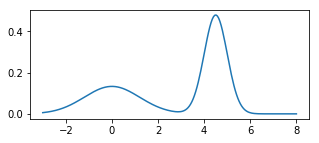

In [3]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; std1=1.2; std2=0.5; pi1=0.4
    return gaussian_mixture(x, mu1, mu2, std1, std2, pi1)

fig, ax = plt.subplots(ncols=1, figsize=(5, 2))
x=np.linspace(-3, 8, 200)
#ax.plot(x, gaussian(x, mu1, std1))
ax.plot(x, gaussian_mixture_fixed(x))
plt.show(fig)
#print('mass of mode 1: {}'.format(pi1*std1))
#print('mass of mode 2: {}'.format((1-pi1)*std2))

In [4]:
# Define distances, p is bimodal with fixed parameters, q is Gaussian
from scipy.integrate import quad
def kl_divergence(params_q, p, q):
    integrand = lambda x: q(x, params_q[0], params_q[1]) * np.log(q(x, params_q[0], params_q[1]) / p(x))
    return quad(integrand, -20, 20)[0]

def alpha_divergence(params_q, p, q, alpha):
    integrand = lambda x: p(x) ** alpha * q(x, params_q[0], params_q[1]) ** (1-alpha)
    return 1/(alpha*(1-alpha))*(1 - quad(integrand, -20, 20)[0])

In [5]:
# set optimization procedure to find parameters mu_q, std_q that minimize the distances
from scipy.optimize import minimize
def minimize_distance(p, q, distance_type, alpha=None, x0=np.array([1, 1]), bounds=None):
    if 'kl' in distance_type.lower():
        res = minimize(kl_divergence, args = (p, q), x0=x0, bounds=bounds)
    elif 'alpha' in distance_type.lower():
        res = minimize(alpha_divergence, args = (p, q, alpha), x0=x0, bounds=bounds)
    return res

In [6]:
print(kl_divergence(params_q=(1, 1), p=gaussian_mixture_fixed, q=gaussian))

1.2250845509363604


In [7]:
# run the optimization problem with KL divergence
x0 = np.array([0, 1])
bounds = [(-10, 10), (0.001, 10)]
kwargs={'x0': x0, 'bounds': bounds}
res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type='kl', 
                        x0=x0, bounds=bounds)
print(res.x)

[1.19046916 2.0333713 ]


In [8]:
# run the optimization problem with KL divergence
for alpha in [0.001, 0.999]:
    x0 = np.array([0, 1])
    bounds = [(-10, 10), (0.001, 10)]
    kwargs={'x0': x0, 'bounds': bounds}
    res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type='alpha', alpha=alpha,
                            x0=x0, bounds=bounds)
    print(res.x)

[1.19309251 2.03444452]
[2.69939973 2.3634745 ]
